## 1. Подготовка среды, чтение metadata.csv в Spark.

In [1]:
import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = (
    SparkSession.builder
    .appName("covid_project")
    .master("local[*]")
    .getOrCreate()
)

spark


In [5]:
metadata_path = "metadata.csv"

df = (
    spark.read
    .option("header", True)       
    .option("inferSchema", True)  
    .csv(metadata_path)
)

df.printSchema()

df.show(5, truncate=False)


root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

In [7]:
# строки
df.count()

# диагнозы
df.select("finding").distinct().show(20, truncate=False)

# снимки
df.select("view").distinct().show()


+---------------------------------------+
|finding                                |
+---------------------------------------+
|Pneumonia/Bacterial/Streptococcus      |
|Pneumonia/Aspiration                   |
|Pneumonia/Lipoid                       |
|Tuberculosis                           |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Bacterial                    |
|Pneumonia/Viral/MERS-CoV               |
|Unknown                                |
|Pneumonia/Viral/Varicella              |
|Pneumonia/Bacterial/Staphylococcus/MRSA|
|Pneumonia/Viral/Influenza/H1N1         |
|Pneumonia/Bacterial/Nocardia           |
|todo                                   |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Viral/Influenza              |
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/SARS                   |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Fungal/Aspergillosis         |
+---------------------------------

## 2. Предобработка, часть анализа качества данных.

In [9]:
from pyspark.sql.types import StringType

rows_before = df.count()
print("Строк до очистки:", rows_before)

df = df.drop("_c29")

df = df.dropDuplicates(["patientid", "offset", "view", "filename"])

rows_after = df.count()
print("Строк после удаления дубликатов:", rows_after)


Строк до очистки: 950
Строк после удаления дубликатов: 950


In [11]:
total = df.count()
print("Всего строк:", total)

missing_counts = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
])

# разворачиваем
missing_long = (
    missing_counts
    .select(
        F.array(*[
            F.struct(F.lit(c).alias("column"), F.col(c).alias("missing"))
            for c in missing_counts.columns
        ]).alias("arr")
    )
    .select(F.explode("arr").alias("m"))
    .select(
        F.col("m.column").alias("column"),
        F.col("m.missing").alias("missing")
    )
    .withColumn("missing_pct", F.col("missing") / F.lit(total))
    .orderBy(F.col("missing_pct").desc())
)

missing_long.show(50, truncate=False)


Всего строк: 950
+----------------------+-------+-------------------+
|column                |missing|missing_pct        |
+----------------------+-------+-------------------+
|leukocyte_count       |934    |0.9831578947368421 |
|neutrophil_count      |922    |0.9705263157894737 |
|extubated             |913    |0.9610526315789474 |
|lymphocyte_count      |910    |0.9578947368421052 |
|temperature           |872    |0.9178947368421052 |
|needed_supplemental_O2|860    |0.9052631578947369 |
|pO2_saturation        |831    |0.8747368421052631 |
|intubated             |702    |0.7389473684210527 |
|intubation_present    |700    |0.7368421052631579 |
|in_icu                |615    |0.6473684210526316 |
|survival              |589    |0.62               |
|doi                   |568    |0.5978947368421053 |
|went_icu              |553    |0.5821052631578948 |
|other_notes           |510    |0.5368421052631579 |
|RT_PCR_positive       |357    |0.3757894736842105 |
|date                  |289  

In [13]:
median_age = df.approxQuantile("age", [0.5], 0.01)[0]
print("Медиана возраста:", median_age)

fill_dict = {
    "age": int(median_age),
    "sex": "Unknown",
    "view": "Unknown",
    "finding": "Unknown"
}

df = df.fillna(fill_dict)


Медиана возраста: 54.0


In [15]:
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in ["age", "sex", "view", "finding"]
]).show()


+---+---+----+-------+
|age|sex|view|finding|
+---+---+----+-------+
|  0|  0|   0|      0|
+---+---+----+-------+



In [51]:
# Создадим новый столбец finding_unified, где соберём диагнозы в 4 группы:

# всё падает, поэтому строку с использоваем закоменчу 
@F.udf(StringType())
def unify_finding_udf(finding):
    if finding is None:
        return "Unknown"
    f = finding.lower()

    if "covid" in f or "sars-cov-2" in f:
        return "COVID-19"
    elif "normal" in f or "no finding" in f:
        return "Normal"
    elif "pneumonia" in f:
        return "Pneumonia (non-COVID)"
    elif "unknown" in f or "todo" in f:
        return "Unknown"
    else:
        return "Other"

# а в теории так:
# df = df.withColumn("finding_unified", unify_finding_udf("finding"))

# рабочий эквивалент:

df = df.withColumn("finding_lower", F.lower("finding"))

df = df.withColumn(
    "finding_unified",
    F.when(
        F.col("finding_lower").contains("covid") |
        F.col("finding_lower").contains("sars-cov-2"),
        "COVID-19"
    ).when(
        F.col("finding_lower").contains("normal") |
        F.col("finding_lower").contains("no finding"),
        "Normal"
    ).when(
        F.col("finding_lower").contains("pneumonia"),
        "Pneumonia (non-COVID)"
    ).when(
        F.col("finding_lower").contains("unknown") |
        F.col("finding_lower").contains("todo"),
        "Unknown"
    ).otherwise("Other")
).drop("finding_lower")


In [48]:
# cделаем возрастные группы:
@F.udf(StringType())
def age_group_udf(age):
    if age is None:
        return "Unknown"
    try:
        a = int(age)
    except Exception:
        return "Unknown"
    if a < 18:
        return "0-17"
    elif a < 40:
        return "18-39"
    elif a < 60:
        return "40-59"
    else:
        return "60+"

# df = df.withColumn("age_group", age_group_udf("age"))

df = df.withColumn(
    "age_group",
    F.when(F.col("age").isNull(), "Unknown")
     .when(F.col("age") < 18, "0-17")
     .when(F.col("age") < 40, "18-39")
     .when(F.col("age") < 60, "40-59")
     .otherwise("60+")
)


In [35]:
df = df.withColumn(
    "date_parsed",
    F.to_date("date", "MMMM d, yyyy")
)

df.createOrReplaceTempView("covid_data")


## 3. SQL-запросы

In [56]:
df = df.withColumn("finding_lower", F.lower("finding"))

df = df.withColumn(
    "finding_unified",
    F.when(
        F.col("finding_lower").contains("covid") |
        F.col("finding_lower").contains("sars-cov-2"),
        "COVID-19"
    ).when(
        F.col("finding_lower").contains("normal") |
        F.col("finding_lower").contains("no finding"),
        "Normal"
    ).when(
        F.col("finding_lower").contains("pneumonia"),
        "Pneumonia (non-COVID)"
    ).when(
        F.col("finding_lower").contains("unknown") |
        F.col("finding_lower").contains("todo"),
        "Unknown"
    ).otherwise("Other")
).drop("finding_lower")

df = df.withColumn(
    "age_group",
    F.when(F.col("age").isNull(), "Unknown")
     .when(F.col("age") < 18, "0-17")
     .when(F.col("age") < 40, "18-39")
     .when(F.col("age") < 60, "40-59")
     .otherwise("60+")
)

df = df.withColumn("date_parsed", F.to_date("date", "MMMM d, yyyy"))

df.createOrReplaceTempView("covid_data")

df.select("finding", "finding_unified", "age", "age_group", "date", "date_parsed").show(5, truncate=False)

+------------------------------+---------------------+---+---------+----+-----------+
|finding                       |finding_unified      |age|age_group|date|date_parsed|
+------------------------------+---------------------+---+---------+----+-----------+
|Pneumonia/Viral/SARS          |Pneumonia (non-COVID)|73 |60+      |2004|NULL       |
|Pneumonia/Viral/SARS          |Pneumonia (non-COVID)|73 |60+      |2004|NULL       |
|Pneumonia/Viral/SARS          |Pneumonia (non-COVID)|73 |60+      |2004|NULL       |
|Pneumonia/Bacterial/Klebsiella|Pneumonia (non-COVID)|62 |60+      |2014|NULL       |
|Pneumonia/Fungal/Pneumocystis |Pneumonia (non-COVID)|40 |40-59    |2014|NULL       |
+------------------------------+---------------------+---+---------+----+-----------+
only showing top 5 rows



In [62]:
# статистика по диагнозам
q1 = spark.sql("""
SELECT
    finding_unified AS diagnosis,
    COUNT(*) AS cnt,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct,
    ROUND(AVG(age), 1) AS avg_age
FROM covid_data
GROUP BY finding_unified
ORDER BY cnt DESC
""")

q1.show(truncate=False)


+---------------------+---+-----+-------+
|diagnosis            |cnt|pct  |avg_age|
+---------------------+---+-----+-------+
|COVID-19             |584|61.47|55.8   |
|Pneumonia (non-COVID)|242|25.47|49.3   |
|Unknown              |84 |8.84 |54.0   |
|Normal               |22 |2.32 |52.5   |
|Other                |18 |1.89 |43.1   |
+---------------------+---+-----+-------+



In [64]:
# распределение по полу и диагнозам
q2 = spark.sql("""
SELECT
    sex,
    finding_unified AS diagnosis,
    COUNT(*) AS cnt
FROM covid_data
GROUP BY sex, finding_unified
ORDER BY sex, cnt DESC
""")

q2.show(50, truncate=False)


+-------+---------------------+---+
|sex    |diagnosis            |cnt|
+-------+---------------------+---+
|F      |COVID-19             |175|
|F      |Pneumonia (non-COVID)|98 |
|F      |Unknown              |23 |
|F      |Normal               |10 |
|F      |Other                |5  |
|M      |COVID-19             |346|
|M      |Pneumonia (non-COVID)|129|
|M      |Unknown              |60 |
|M      |Other                |13 |
|M      |Normal               |11 |
|Unknown|COVID-19             |63 |
|Unknown|Pneumonia (non-COVID)|15 |
|Unknown|Normal               |1  |
|Unknown|Unknown              |1  |
+-------+---------------------+---+



In [74]:
from pyspark.sql import functions as F

spark.conf.set("spark.sql.legacy.timeParserPolicy", "CORRECTED")

# пересоздаём колонку date_parsed с несколькими  форматами
df = df.drop("date_parsed") 

df = df.withColumn(
    "date_parsed",
    F.coalesce(
        F.to_date("date", "MMMM d, yyyy"),   
        F.to_date("date", "MMM d, yyyy"),   
        F.to_date("date")                    
    )
)

df.select("date", "date_parsed").show(20, truncate=False)


+----+-----------+
|date|date_parsed|
+----+-----------+
|2004|2004-01-01 |
|2004|2004-01-01 |
|2004|2004-01-01 |
|2014|2014-01-01 |
|2014|2014-01-01 |
|2014|2014-01-01 |
|2014|2014-01-01 |
|2007|2007-01-01 |
|2010|2010-01-01 |
|2015|2015-01-01 |
|2010|2010-01-01 |
|2010|2010-01-01 |
|2016|2016-01-01 |
|2015|2015-01-01 |
|2015|2015-01-01 |
|2015|2015-01-01 |
|2015|2015-01-01 |
|2020|2020-01-01 |
|2016|2016-01-01 |
|2016|2016-01-01 |
+----+-----------+
only showing top 20 rows



In [70]:
df.createOrReplaceTempView("covid_data")


In [72]:
q3 = spark.sql("""
SELECT
    finding_unified AS diagnosis,
    patientid,
    age,
    sex,
    view,
    date_parsed,
    rn
FROM (
    SELECT
        finding_unified,
        patientid,
        age,
        sex,
        view,
        date_parsed,
        ROW_NUMBER() OVER (
            PARTITION BY finding_unified
            ORDER BY age DESC
        ) AS rn
    FROM covid_data
    WHERE age IS NOT NULL
) t
WHERE rn <= 3
ORDER BY diagnosis, age DESC
""")

q3.show(truncate=False)


+---------------------+---------+---+---+---------+-----------+---+
|diagnosis            |patientid|age|sex|view     |date_parsed|rn |
+---------------------+---------+---+---+---------+-----------+---+
|COVID-19             |326b     |94 |M  |AP       |2020-01-01 |1  |
|COVID-19             |324b     |93 |F  |AP       |2020-01-01 |2  |
|COVID-19             |324b     |93 |F  |AP       |2020-01-01 |3  |
|Normal               |315      |78 |F  |PA       |2020-03-04 |1  |
|Normal               |325      |78 |F  |AP       |NULL       |2  |
|Normal               |313b     |75 |M  |AP       |2020-01-01 |3  |
|Other                |421      |78 |M  |PA       |NULL       |1  |
|Other                |453      |70 |M  |AP       |NULL       |2  |
|Other                |456      |58 |M  |L        |NULL       |3  |
|Pneumonia (non-COVID)|460      |90 |M  |L        |NULL       |1  |
|Pneumonia (non-COVID)|460      |90 |M  |PA       |NULL       |2  |
|Pneumonia (non-COVID)|340      |80 |M  |L      

In [76]:
q4 = spark.sql("""
SELECT
    DATE_FORMAT(date_parsed, 'yyyy-MM') AS year_month,
    finding_unified AS diagnosis,
    COUNT(*) AS cnt
FROM covid_data
WHERE date_parsed IS NOT NULL
GROUP BY DATE_FORMAT(date_parsed, 'yyyy-MM'), finding_unified
ORDER BY year_month, diagnosis
""")

q4.show(50, truncate=False)


+----------+---------------------+---+
|year_month|diagnosis            |cnt|
+----------+---------------------+---+
|2004-01   |Pneumonia (non-COVID)|11 |
|2007-01   |Pneumonia (non-COVID)|1  |
|2009-09   |Pneumonia (non-COVID)|3  |
|2010-01   |Pneumonia (non-COVID)|3  |
|2010-05   |Pneumonia (non-COVID)|2  |
|2010-10   |Pneumonia (non-COVID)|1  |
|2011-01   |Pneumonia (non-COVID)|5  |
|2013-01   |Pneumonia (non-COVID)|7  |
|2014-01   |Pneumonia (non-COVID)|11 |
|2015-01   |Pneumonia (non-COVID)|24 |
|2015-05   |Pneumonia (non-COVID)|1  |
|2016-01   |Pneumonia (non-COVID)|20 |
|2017-01   |Pneumonia (non-COVID)|3  |
|2017-06   |Pneumonia (non-COVID)|1  |
|2018-01   |Pneumonia (non-COVID)|6  |
|2019-01   |Normal               |2  |
|2019-02   |Pneumonia (non-COVID)|1  |
|2019-05   |Pneumonia (non-COVID)|1  |
|2019-12   |COVID-19             |4  |
|2020-01   |COVID-19             |393|
|2020-01   |Normal               |7  |
|2020-01   |Unknown              |83 |
|2020-02   |COVID-19     

In [78]:
q5 = spark.sql("""
SELECT
    view,
    finding_unified AS diagnosis,
    COUNT(*) AS cnt,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY view), 2) AS pct_within_view
FROM covid_data
GROUP BY view, finding_unified
ORDER BY view, cnt DESC
""")

q5.show(50, truncate=False)


+---------+---------------------+---+---------------+
|view     |diagnosis            |cnt|pct_within_view|
+---------+---------------------+---+---------------+
|AP       |COVID-19             |146|71.92          |
|AP       |Pneumonia (non-COVID)|50 |24.63          |
|AP       |Normal               |5  |2.46           |
|AP       |Other                |2  |0.99           |
|AP Erect |Pneumonia (non-COVID)|1  |100.00         |
|AP Supine|COVID-19             |136|58.12          |
|AP Supine|Unknown              |72 |30.77          |
|AP Supine|Pneumonia (non-COVID)|23 |9.83           |
|AP Supine|Normal               |3  |1.28           |
|Axial    |COVID-19             |64 |94.12          |
|Axial    |Normal               |4  |5.88           |
|Coronal  |COVID-19             |16 |100.00         |
|L        |Pneumonia (non-COVID)|51 |60.71          |
|L        |COVID-19             |26 |30.95          |
|L        |Other                |7  |8.33           |
|PA       |COVID-19         

## 4. Обработка в PySpark

In [86]:
# отфильрем данные по критериям 
filtered_df = df.filter(
    (F.col("modality") == "X-ray") &
    (F.col("finding_unified") != "Unknown") &
    (F.col("age") >= 0) & (F.col("age") <= 120) &
    (F.col("view").isNotNull())
)

print("Всего строк в исходном df:", df.count())
print("Строк после фильтрации:", filtered_df.count())

filtered_df.select("patientid", "age", "sex", "finding_unified", "view").show(10, truncate=False)


Всего строк в исходном df: 950
Строк после фильтрации: 782
+---------+---+-------+---------------------+----+
|patientid|age|sex    |finding_unified      |view|
+---------+---+-------+---------------------+----+
|10       |73 |F      |Pneumonia (non-COVID)|AP  |
|10       |73 |F      |Pneumonia (non-COVID)|AP  |
|10       |73 |F      |Pneumonia (non-COVID)|AP  |
|100      |62 |F      |Pneumonia (non-COVID)|PA  |
|101      |40 |F      |Pneumonia (non-COVID)|PA  |
|101      |40 |F      |Pneumonia (non-COVID)|PA  |
|101      |40 |F      |Pneumonia (non-COVID)|PA  |
|102      |54 |Unknown|Pneumonia (non-COVID)|PA  |
|103      |54 |Unknown|Pneumonia (non-COVID)|PA  |
|104      |54 |Unknown|Pneumonia (non-COVID)|PA  |
+---------+---+-------+---------------------+----+
only showing top 10 rows



In [88]:
filtered_df = filtered_df.filter(
    F.col("finding_unified").isin("COVID-19", "Pneumonia (non-COVID)", "Normal")
)
print("После дополнительного фильтра:", filtered_df.count())


После дополнительного фильтра: 764


In [105]:
import os

# конвертируем
filtered_pd = filtered_df.toPandas()

output_dir = "processed_parquet_pd"
os.makedirs(output_dir, exist_ok=True)

parquet_path = os.path.join(output_dir, "covid_filtered.parquet")

# сохраняем Parquet с помощью pyarrow
filtered_pd.to_parquet(parquet_path, index=False)

print("Parquet сохранён в файл:", parquet_path)
print("Строк в сохранённом наборе:", len(filtered_pd)) 


# из-за ограничений при записи через df.write.parquet возникает ошибка. 
# Поэтому для сохранения результатов исп. конвертацию через pd, но формат parquet мы оставляем тот же. 


Parquet сохранён в файл: processed_parquet_pd\covid_filtered.parquet
Строк в сохранённом наборе: 764


## 5. Визаулизация:

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (6, 4)


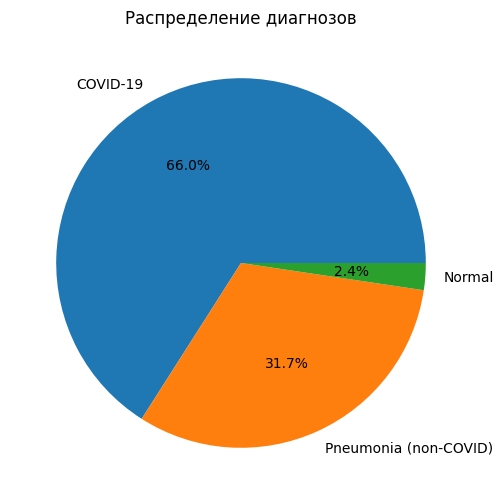

In [111]:
diag_spark = (
    filtered_df
    .groupBy("finding_unified")
    .count()
    .orderBy("count", ascending=False)
)

diag_pd = diag_spark.toPandas()

plt.figure(figsize=(6, 6))
plt.pie(diag_pd["count"], labels=diag_pd["finding_unified"], autopct="%1.1f%%")
plt.title("Распределение диагнозов")
plt.show()


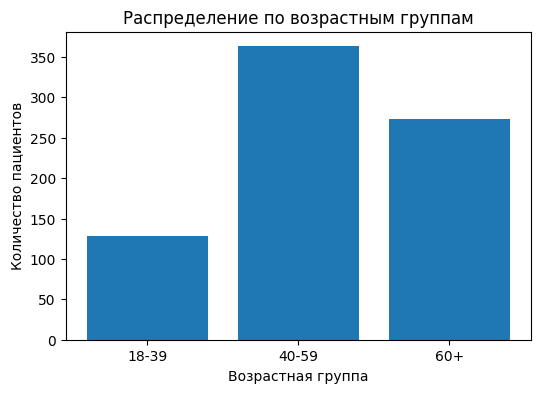

In [113]:
age_spark = (
    filtered_df
    .groupBy("age_group")
    .count()
    .orderBy("age_group")
)

age_pd = age_spark.toPandas()

plt.figure()
plt.bar(age_pd["age_group"], age_pd["count"])
plt.title("Распределение по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Количество пациентов")
plt.show()


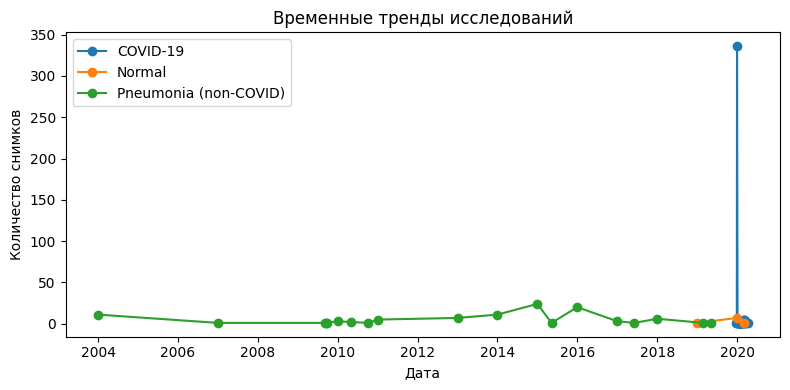

In [115]:
trend_spark = (
    filtered_df
    .where(F.col("date_parsed").isNotNull())
    .groupBy("date_parsed", "finding_unified")
    .count()
    .orderBy("date_parsed")
)

trend_pd = trend_spark.toPandas()

plt.figure(figsize=(8, 4))
for diag, grp in trend_pd.groupby("finding_unified"):
    plt.plot(grp["date_parsed"], grp["count"], marker="o", label=diag)

plt.title("Временные тренды исследований")
plt.xlabel("Дата")
plt.ylabel("Количество снимков")
plt.legend()
plt.tight_layout()
plt.show()


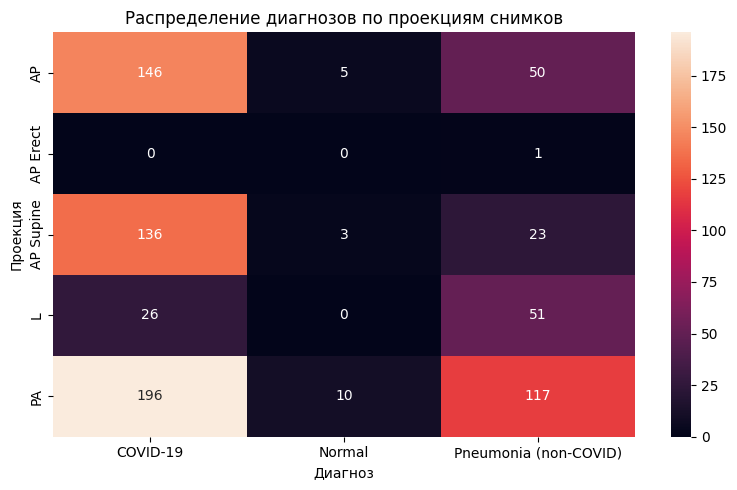

In [119]:
heat_spark = (
    filtered_df
    .groupBy("view", "finding_unified")
    .count()
)

heat_pd = heat_spark.toPandas()
heat_pivot = heat_pd.pivot(index="view", columns="finding_unified", values="count").fillna(0)

plt.figure(figsize=(8, 5))
sns.heatmap(heat_pivot, annot=True, fmt=".0f")
plt.title("Распределение диагнозов по проекциям снимков")
plt.xlabel("Диагноз")
plt.ylabel("Проекция")
plt.tight_layout()
plt.show()
